# Esplorazione dati

 Il **Fluorescent Neuronal Cells dataset** [(Clissa et al., 2021)](http://amsacta.unibo.it/6706/) è una raccolta di *283* foto ad alta risoluzione (1200x1600 pixel) e le relative annotazioni a livello di pixel.
Queste immagini raffigurano fettine di cervello di roditori fotografate con un microscopio a fluorescenza.
 
 I neuroni di interesse risultano evidenziati come macchie gialle di varia forma, grandezza e colore, adagiate su uno sfondo anch'esso variabile ma generalmente più scuro.

 In questo notebook esploreremo il nostro dataset, cercando di capirne le particolarità e pianificando gli step necessari per la sua analisi.

## Download dati

Per prima cosa scarichiamo i dati dal [repository ufficiale](http://amsacta.unibo.it/6706/):

In [ ]:
!sudo apt-get install -q tree
!wget http://amsacta.unibo.it/6706/1/fluocells.zip
!unzip fluocells.zip -d fluocells_data

Una volta scaricati, i dati si troveranno nella cartella `fluocells_data`.

In particolare, le immagini saranno disponibili in formato *png* al percorso `all_images/images`, mentre le corrispondenti maschere si troveranno nella cartella `all_masks/masks`.

In pratica, useremo le immagini come dati di input da fornire al nostro modello e le maschere come *label*, cioè esempi di output che vogliamo riprodurre e dai quali il nostro modello dovrà imparare.

>**Nota:** il concetto di *label* o *etichetta* da cui il modello impara viene comunemente espresso attraverso vari termini quali *maschera*, *annotazione* e *ground-truth*. In questo corso, questi termini verranno usati intercambiabilmente per indicare gli **esempi di output desiderato che il modello deve imparare a replicare**.

In [3]:
!tree -L 2 ../fluocells_data

../fluocells_data
├── all_images
│   ├── colorspace
│   ├── images
│   └── LICENSE.txt
├── all_masks
│   ├── LICENSE.txt
│   ├── masks
│   └── stats_df.csv
└── README.md

5 directories, 4 files


## Immagini campione

Per prima cosa possiamo visualizzare come sono fatte alcune di queste immagini. 

Possiamo utilizzare diverse librerie, ognuna con qualche particolarità. Per il momento useremo [scikit-image](https://scikit-image.org/docs/dev/install.html) per importare le immagini e [matplotlib](https://matplotlib.org/) per visualizzarle, ma altre alternative sono altrettanto valide.

<div class="alert alert-block alert-info">

Prova ad esplorare il dataset in autonomia, ti basterà cambiare `sample_img_names` inserendo i nomi delle immagini che vuoi visualizzare!

</div>

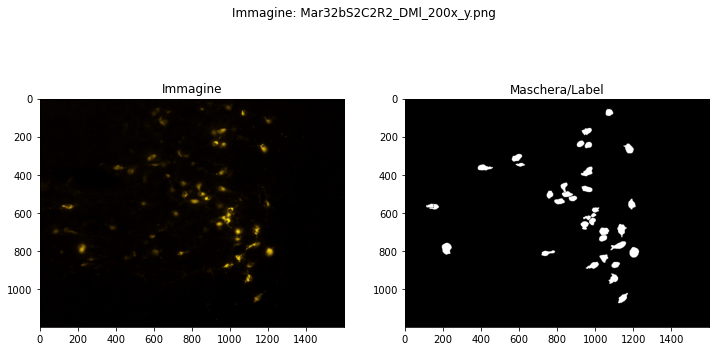

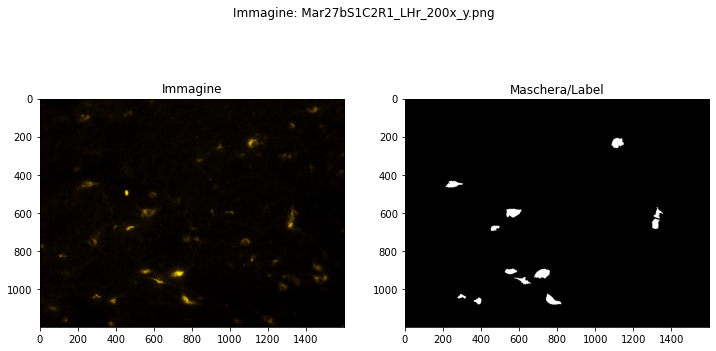

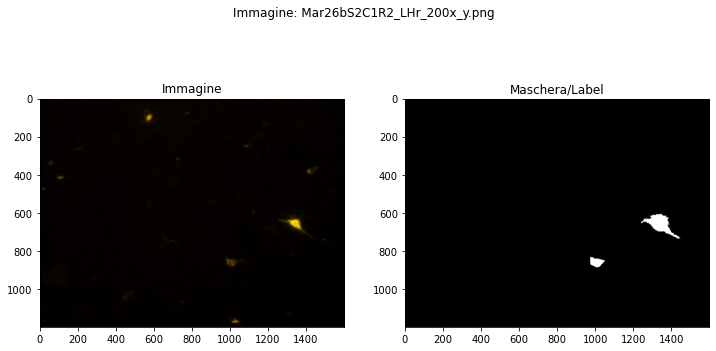

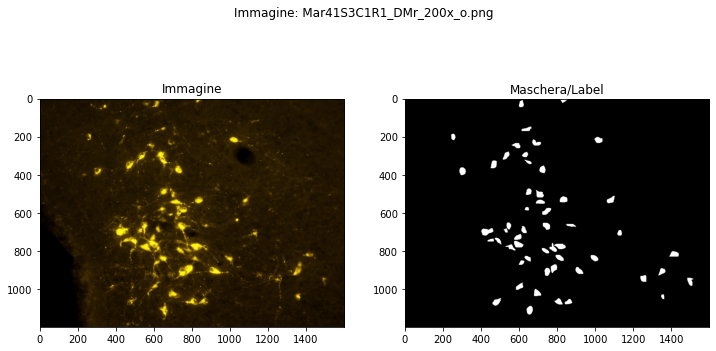

In [1]:
import skimage.io as io
from pathlib import Path
import matplotlib.pyplot as plt

IMG_PATH = Path('../fluocells_data/all_images/images')
MASK_PATH = Path('../fluocells_data/all_masks/masks')

sample_img_names = ['Mar32bS2C2R2_DMl_200x_y.png', 'Mar27bS1C2R1_LHr_200x_y.png',
                    'Mar26bS2C1R2_LHr_200x_y.png', 'Mar41S3C1R1_DMr_200x_o.png']

for img_name in sample_img_names:                    
    img = io.imread(IMG_PATH / img_name)
    mask = io.imread(MASK_PATH / img_name, as_gray=True)



    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f'Immagine: {img_name}')
    ax[0].imshow(img)
    ax[0].set_title('Immagine')
    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title('Maschera/Label')
    plt.show()

> Le maschere non sono altro che una "legenda" dove per ad ogni pixel viene associato il colore:
> - **bianco** se appartiene ad una cellula
> - **nero** se appartiene allo sfondo.

## Formato immagini

Dopo una prima ispezione a livello puramente visivo, è sempre molto utile controllare alcune caratteristiche più quantitative.

Per prima cosa, possiamo analizzare la forma e l'encoding delle immagini.

In [2]:
import numpy as np
for img_name in sample_img_names:                    
    img = io.imread(IMG_PATH / img_name)
    mask = io.imread(MASK_PATH / img_name, as_gray=True)

    print(f'\n\n - {img_name}\n\nImmagine\ntype: {type(img)} - {img.dtype}\nshape: {img.shape}')
    print(f'\nMaschera\ntype: {type(mask)} - {mask.dtype}\nshape: {mask.shape}\nunique values: {np.unique(mask)}')



 - Mar32bS2C2R2_DMl_200x_y.png

Immagine
type: <class 'numpy.ndarray'> - uint8
shape: (1200, 1600, 3)

Maschera
type: <class 'numpy.ndarray'> - float64
shape: (1200, 1600)
unique values: [0. 1.]


 - Mar27bS1C2R1_LHr_200x_y.png

Immagine
type: <class 'numpy.ndarray'> - uint8
shape: (1200, 1600, 3)

Maschera
type: <class 'numpy.ndarray'> - float64
shape: (1200, 1600)
unique values: [0. 1.]


 - Mar26bS2C1R2_LHr_200x_y.png

Immagine
type: <class 'numpy.ndarray'> - uint8
shape: (1200, 1600, 3)

Maschera
type: <class 'numpy.ndarray'> - float64
shape: (1200, 1600)
unique values: [0. 1.]


 - Mar41S3C1R1_DMr_200x_o.png

Immagine
type: <class 'numpy.ndarray'> - uint8
shape: (1200, 1600, 3)

Maschera
type: <class 'numpy.ndarray'> - float64
shape: (1200, 1600)
unique values: [0. 1.]


Le **immagini** sono rappresentate attraverso la **codifica RGB**, i.e. ogni pixel è espresso come combinazione di 3 colori: *rosso (R)*, *verde (G)* e *blu (B)*, rispettivamente.

In particolare, scikit image restituisce dei *numpy array* aventi una forma (H, W, C) dove *H* determina l'*altezza*, *W* la *larghezza* e *C* i numero di *canali* per la codifica del colore.
Nel nostro caso, le immagini sono di 1200 x 1600 pixel (px), con 3 canali per i valori di rosso, verde e blu.

Le **maschere**, invece, sono lette con **codifica grayscale** grazie all'aggiunta dell'attributo `as_gray=True` in `skimage.io.imread`. 
In particolare, ciascuna maschera ha lo stesso numero di pixel dell'immagine corrispondente, e ogni pixel è riempito con un colore a seconda della classe (cellula o sfondo) a cui esso appartiene. 

Questo è sufficiente dal momento che abbiamo bisogno di *maschere binarie*, i.e. con due soli valori distinti, uno per lo sfondo (nero) e uno per le cellule (bianco).

<div class="alert alert-block alert-info">

**Nota:** le maschere sono in *type uint16*, per cui la scala di grigio corrispondente va da *0 ⟶ nero* a *65535 ⟶ bianco*. Nel seguito vedremo come convertirle in altri formati più convenienti per le nostre analisi.

</div>

<div class="alert alert-block alert-warning">

**Nota 2:** Non tutte le maschere sono già binarizzate (vedi lista valori unici). Inoltre, il processo di annotazione è soggetto ad errori occasionali che comportano la presenza di artefatti di varia natura (es. presenza di pixel isolati etichettati come cellule). Per questi motivi, sarà necessario prima fare un po' di pulizia.
    
</div>

## Pulizia maschere

Le operazioni di *data cleaning* che opereremo sono 2:

 - **Binarizzazione** (anche detta *thresholding*): tutti i pixel con valori `>0` verrà assegnato valore `255` e saranno quindi considerati come cellule
 - **Rimozione oggetti piccoli**: tutte le cellule con area `<150` pixel verranno scartati
 
Le maschere risultanti verranno poi sovrascritte su quelle originali.

In [3]:
from tqdm import tqdm
from skimage.morphology import remove_small_objects
from skimage import measure


def remove_noise_from_masks(masks_path, out_path, min_obj_size=150, connectivity=1):
    for p in tqdm([*masks_path.iterdir()]):
        mask = io.imread(p, as_gray=True)
        
        # binarizzazione
        mask[mask > 0] = 255
        # remove small objects
        label = measure.label(mask, connectivity=connectivity)
        remove_small_objects(label, min_size=min_obj_size,
                             connectivity=connectivity, in_place=True)
        label[label > 0] = 255

        # fix filename and change format
        out_path = out_path if out_path.name == "masks" else out_path / 'masks'
        out_path.mkdir(parents=True, exist_ok=True)

        # filename = p.name.split('.')[0] + '.png'
        # outname = str(out_path / fix_mask_filename(filename))
        outname = str(out_path / p.name)
        plt.imsave(fname=outname, arr=label, cmap='gray')
    return


remove_noise_from_masks(MASK_PATH, MASK_PATH)

  1%|          | 2/283 [00:00<01:08,  4.09it/s]<ipython-input-3-1b06b2767462>:14: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  remove_small_objects(label, min_size=min_obj_size,
100%|██████████| 283/283 [01:08<00:00,  4.11it/s]


In [4]:
for img_name in sample_img_names:
    img = io.imread(IMG_PATH / img_name)
    mask = io.imread(MASK_PATH / img_name, as_gray=True)

    print(
        f'\n\n - {img_name}\n\nImmagine\ntype: {type(img)} - {img.dtype}\nshape: {img.shape}')
    print(
        f'\nMaschera\ntype: {type(mask)} - {mask.dtype}\nshape: {mask.shape}\nunique values: {np.unique(mask)}')



 - Mar32bS2C2R2_DMl_200x_y.png

Immagine
type: <class 'numpy.ndarray'> - uint8
shape: (1200, 1600, 3)

Maschera
type: <class 'numpy.ndarray'> - float64
shape: (1200, 1600)
unique values: [0. 1.]


 - Mar27bS1C2R1_LHr_200x_y.png

Immagine
type: <class 'numpy.ndarray'> - uint8
shape: (1200, 1600, 3)

Maschera
type: <class 'numpy.ndarray'> - float64
shape: (1200, 1600)
unique values: [0. 1.]


 - Mar26bS2C1R2_LHr_200x_y.png

Immagine
type: <class 'numpy.ndarray'> - uint8
shape: (1200, 1600, 3)

Maschera
type: <class 'numpy.ndarray'> - float64
shape: (1200, 1600)
unique values: [0. 1.]


 - Mar41S3C1R1_DMr_200x_o.png

Immagine
type: <class 'numpy.ndarray'> - uint8
shape: (1200, 1600, 3)

Maschera
type: <class 'numpy.ndarray'> - float64
shape: (1200, 1600)
unique values: [0. 1.]


## Caratteristiche cellule

Come anticipato, le cellule presentano una grande varietà di forme, dimensioni e tonalità. In questa sezione andremo ad analizzare più nel dettaglio le loro caratteristiche.

In [5]:
import pandas as pd


def compute_masks_stats(masks_path):
    """
    Read ground-truth masks and compute metrics for cell counts and shapes
    :param masks_path: Pathlib.Path() to masks folder
    :return:
    """
    paths = [*masks_path.iterdir()]
    data = []
    for idx_image, p in tqdm(enumerate(paths), total=len(paths)):
        mask = io.imread(p, as_gray=True)
        skimage_label, n_objs = measure.label(
            mask, connectivity=1, return_num=True)

        # add one row per object
        for idx_obj, obj in enumerate(measure.regionprops(skimage_label)):
            data.append([
                p.name.split('.')[0],
                int(n_objs),
                idx_obj,
                int(obj.area),
                obj.minor_axis_length,
                obj.major_axis_length,
                obj.equivalent_diameter,
                obj.feret_diameter_max,
            ])

        # add empty row in case image has no objects
        if n_objs == 0:
            data.append([
                p.name.split('.')[0],
                int(n_objs),
                None, None, None, None, None, None,
            ])

    # store stats in dataframe
    stats_df = pd.DataFrame(data=data,
                            columns=[
                                'img_name',
                                'n_cells',
                                'cell_id',
                                'area',
                                'min_axis_length',
                                'max_axis_length',
                                'equivalent_diameter',
                                'feret_diameter_max',
                            ])
    # save stats dataframe
    stats_df.round(4).to_csv(masks_path.parent / 'stats_df.csv', index=False)
    return stats_df


stats_df = compute_masks_stats(MASK_PATH)
stats_df

100%|██████████| 283/283 [00:46<00:00,  6.07it/s]


,img_name,n_cells,cell_id,area,min_axis_length,max_axis_length,equivalent_diameter,feret_diameter_max
0,Mar26bS2C1R2_LHl_200x_y,4,0.0,2281.0,51.022976,65.864957,53.891181,77.420927
1,Mar26bS2C1R2_LHl_200x_y,4,1.0,3058.0,47.316360,88.148375,62.398450,92.114060
2,Mar26bS2C1R2_LHl_200x_y,4,2.0,2114.0,51.938794,73.340206,51.880906,82.054860
3,Mar26bS2C1R2_LHl_200x_y,4,3.0,2849.0,52.343663,82.964642,60.228394,93.770998
4,Mar26bS1C2R1_VLPAGr_200x_y,2,0.0,1699.0,36.983734,60.731244,46.510579,74.545288
...,...,...,...,...,...,...,...,...
2226,Mar24bS2C4R3_LHl_200x_y,6,1.0,2750.0,48.078076,75.603321,59.172703,80.230917
2227,Mar24bS2C4R3_LHl_200x_y,6,2.0,3192.0,50.624501,89.902669,63.750926,111.830228
2228,Mar24bS2C4R3_LHl_200x_y,6,3.0,1904.0,30.324455,87.141605,49.236654,101.533246
2229,Mar24bS2C4R3_LHl_200x_y,6,4.0,4511.0,55.753734,107.549398,75.786434,125.207827


### Tabella riassuntiva

In [6]:
qq = [0.1, 0.25, 0.5, 0.75, 0.9]

summary = stats_df.describe(percentiles=qq).round(4)
summary

,n_cells,cell_id,area,min_axis_length,max_axis_length,equivalent_diameter,feret_diameter_max
count,2231.0000,2179.0000,2179.0000,2179.0000,2179.0000,2179.0000,2179.0000
mean,27.8077,13.7357,1511.6925,33.6400,56.6111,41.3577,61.9104
std,22.4573,15.2749,1156.4980,12.7576,24.0548,14.6418,28.7734
min,0.0000,0.0000,151.0000,8.7011,14.7281,13.8658,16.2788
10%,4.0000,0.0000,496.8000,19.8306,32.4127,25.1505,34.1321
25%,7.0000,2.0000,764.5000,24.5290,40.5369,31.1992,42.7200
50%,21.0000,7.0000,1170.0000,31.3391,51.3194,38.5965,54.9181
75%,51.0000,21.0000,1886.0000,40.3317,67.4972,49.0034,74.1215
90%,60.0000,38.2000,2915.0000,50.2636,86.9102,60.9220,96.8184
max,69.0000,68.0000,9360.0000,97.4496,205.7924,109.1674,257.3888


In totale abbiamo **2179 cellule** distribuite in 231 immagini, le restanti 52 invece non contengono alcuna cellula.

Dai percentili riportati in tabella è possibile notare come ci sia una grande varietà di forme e dimensioni. 

Inoltre anche la quantità di cellule presenti in ogni immagine varia da zero o poche unità a diverse decine.

Di seguito sono riportati alcuni grafici per ispezionare visivamente le distribuzioni delle caratteristiche più significative.

<div class="alert alert-block alert-info">
    
**Feret diameter:** lunghezza massima tra punti sullo stesso contorno convesso. Per maggiori informazioni: [[1]](https://en.wikipedia.org/wiki/Feret_diameter), [[2]](https://it.wikipedia.org/wiki/Diametro_sferico_equivalente), [[3]](https://scikit-image.org/docs/0.18.x/api/skimage.measure.html?highlight=feret)
    
</div>

<div class="alert alert-block alert-info">
    
La differenza in `count` tra `n_cells` e le altre colonne è dovuta alle 52 immagini senza cellule.
    
</div>

### Grafici distribuzioni

In [14]:
import plotly.graph_objects as go


layout = {
    'template': "plotly_white",
    'paper_bgcolor': 'rgba(0,0,0,0)',
    'plot_bgcolor': 'rgba(0,0,0,0)',
    'title': {
        'x': 0.5, 'xanchor': 'center'
    },
    'font': dict(
        family="Helvetica",
        size=12,
    ),
    'showlegend': False,
    'autosize': False,
    'width': 440,
    'height': 440,
    'margin': dict(l=0, r=0, t=0, b=0),
}
colors = ["#FB8537", "#188BC9"]


fig = go.Figure(layout=layout)
resolution = 1

viol = fig.add_trace(
    go.Violin(y=stats_df['feret_diameter_max']/resolution,
              box_visible=True, line_color='black',
              meanline_visible=True, fillcolor=colors[1], opacity=0.6,
              spanmode='hard',
              ),
)

_ = fig.update_yaxes(title='maximum Feret diameter (pixels)')
_ = fig.update_xaxes(visible=False)

fig.show()

Per il diametro di Feret massimo, abbiamo media e mediana tra 55 e 60 pixel (**55 e 62, rispettivamente**). La distribuzione è concentrata su valori bassi (**range interquartile tra 42 e 74 pixel**), con una coda prolungata fino a oltre 200 pixel.

In [8]:
fig = go.Figure(layout=layout)

viol = fig.add_trace(
    go.Violin(y=stats_df['area'] / resolution**2, 
              box_visible=True, line_color='black',
              meanline_visible=True, fillcolor=colors[0], opacity=0.6,
              spanmode='hard',
              ),
)

_ = fig.update_yaxes(title='area (pixels<sup>2</sup>)')
_ = fig.update_xaxes(visible=False)

fig.show()

Riguardo l'area invece, abbiamo **media e mediana tra 1170 e 1511 pixel**. Anche in questo caso la distribuzione è concentrata su valori bassi (**range interquartile tra 764 e 1886 pixel**), con una coda prolungata fino a oltre 6000 pixel.

In [9]:
fig = go.Figure(layout=layout)

_ = fig.add_trace(go.Histogram(x=stats_df['n_cells'], nbinsx=70,
                               marker_color="#98E2C6", opacity=0.6,
                               )
                  )
_ = fig.update_yaxes(title='# images')
_ = fig.update_xaxes(title='# cells') 

fig.show()

Infine, le immagini presentano circa **28 cellule in media (mediana pari a 21**). 
La distribuzione risulta multimodale, con un **primo picco al di sotto delle 20 unità** seguito da gruppi di immagini con un numero crescente di cellule, **fino a diverse decine**.

## Colorspace

In [10]:
import cv2

def plot_3Dcolorspace(img, colorspace=['RGB', 'HSV'], img_name=None):
    '''Plot pixel into 3D colorspace.

    Keyword arguments:
    img -- array with rgb image
    colorspace -- list with names of the colorspace to consider; only rgb and hsv supported
    img_name -- name of the image to use as title of the plot

    Return: fig
    '''
    from matplotlib import colors
    elev, azim = 25, 45
    ls = 2

    # store pixel colors into a list
    pixel_colors = img.reshape((np.shape(img)[0]*np.shape(img)[1], 3))
    norm = colors.Normalize(vmin=-1., vmax=1.)
    norm.autoscale(pixel_colors)
    pixel_colors = norm(pixel_colors).tolist()

    # print 3D scatterplot of pixels into the appropriate colorspace

    # RGB
    fig = plt.figure(figsize=(15, 8))
    axis = fig.add_subplot(1, 2, 1, projection="3d")
    r, g, b = cv2.split(img)
    axis.scatter(r.flatten(),
                 g.flatten(),
                 b.flatten(),
                 facecolors=pixel_colors, marker=".")
    axis.view_init(elev, azim)
    axis.set_xlabel("\n Red ", linespacing=ls)
    axis.set_ylabel("\nGreen", linespacing=ls)
    axis.set_zlabel("\n Blue", linespacing=ls)
    plt.title("{} colorspace".format(colorspace[0]))

    # HSV
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv_img)
    axis = fig.add_subplot(1, 2, 2, projection="3d")
    axis.scatter(h.flatten(), s.flatten(), v.flatten(),
                 facecolors=pixel_colors, marker=".")
    axis.view_init(elev, azim)
    axis.set_xlabel("\n Hue ", linespacing=ls)
    axis.set_ylabel("\nSaturation", linespacing=ls)
    axis.set_zlabel("\nValue", linespacing=ls)
    plt.title("{} colorspace".format(colorspace[1]))
    if img_name:
        fig.suptitle(img_name)
    plt.show()
    return fig

  0%|          | 0/4 [00:00<?, ?it/s]

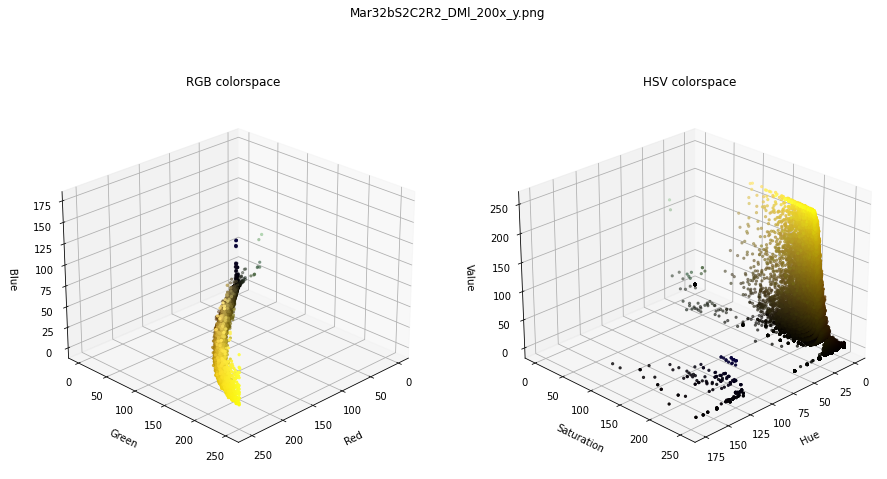

 25%|██▌       | 1/4 [00:45<02:16, 45.48s/it]

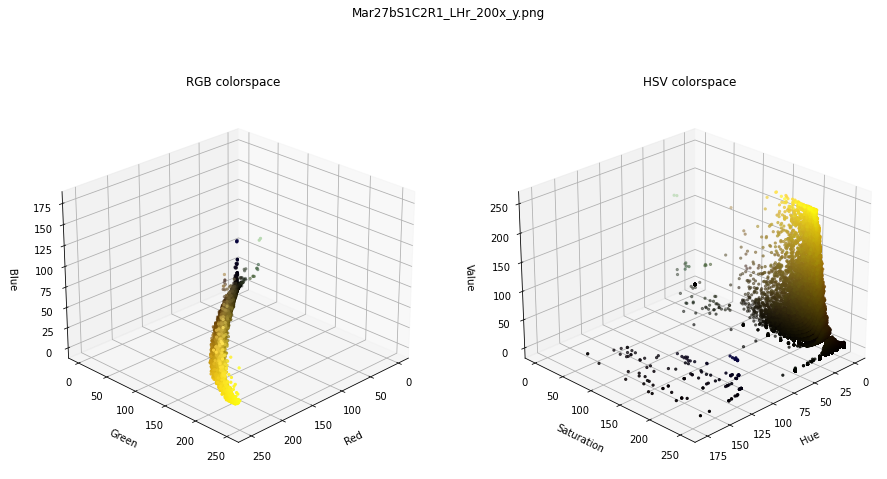

 50%|█████     | 2/4 [01:31<01:31, 45.53s/it]

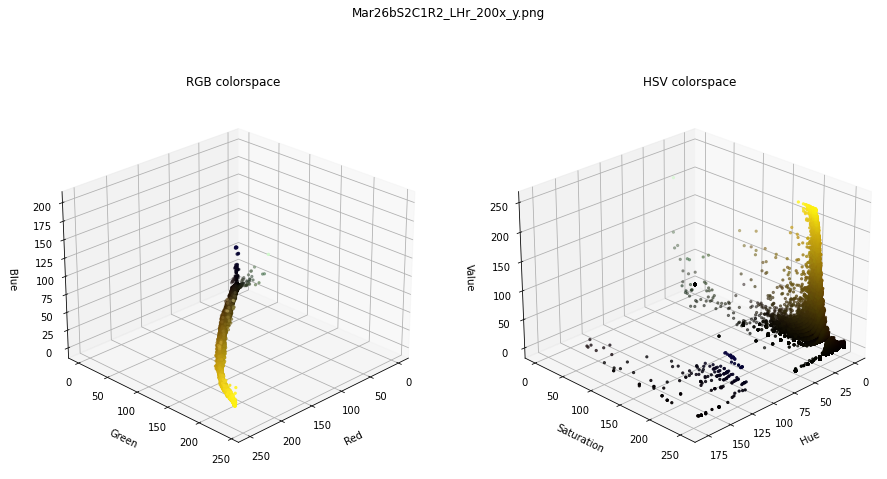

 75%|███████▌  | 3/4 [02:17<00:46, 46.05s/it]

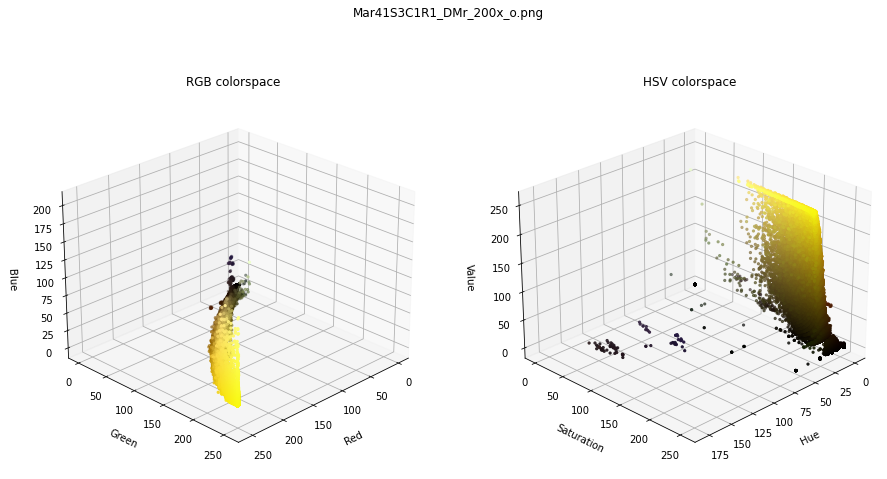

100%|██████████| 4/4 [02:59<00:00, 44.96s/it]

CPU times: user 3min 18s, sys: 5.8 s, total: 3min 24s
Wall time: 2min 59s


In [11]:
%%time 

for img_name in tqdm(sample_img_names):
    img = io.imread(IMG_PATH / img_name)
    plot_3Dcolorspace(img, img_name=img_name)

L'**encoding RGB** sembra non essere una rappresentazione ottimale nel nostro caso. **Le tonalità di colore sono infatti concentrate nel piano verde/rosso**.
    
Per di più, i pixel sembrano quasi essere allineati lungo la bisettrice di tale piano, suggerendo che un colorspace tridimensionale non sia necessario e che probabilmente una alternativa ad una sola dimensione potrebbe essere sufficiente.
    
<div class="alert alert-block alert-info">

Questo conferma l'impressione visiva che le immagini sono di fatto **scale di giallo**, che per l'appunto è espresso cromaticamente come combinazione di rosso e verde.
</div>

L'**encoding HSV** invece mostra una maggiore distribuzione dei pixel sulle 3 dimensioni, suggerendo che probabilmente altri colorspace potrebbero rendere più facile la separazione delle tonalità dei pixel appartenenti alle cellule e di quelli appartenenti allo sfondo.

<div class="alert alert-block alert-info">

Nel seguito sfrutteremo queste osservazioni per cercare di ottenere il migliore encoding  possibile per il nostro problema.
</div>